# Introduction

The 2019-nCoV is a contagious coronavirus that hailed from Wuhan (Hubei province), China. This new strain of virus has striked fear in many countries as cities are quarantined and hospitals are overcrowded.

This dataset contains data that was released by Johns Hopkins University.

# Analysis preparation

## Load packages

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import folium
%matplotlib inline

## Load the data

There are multiple files in the coronavirus data folder, we will take the last updated one.
We also include GeoJSON data for China and for World.

In [2]:
print(os.listdir('/kaggle/input'))
DATA_FOLDER = "/kaggle/input/2019-coronavirus-dataset-01212020-01262020"
print(os.listdir(DATA_FOLDER))
GEO_DATA = "/kaggle/input/china-regions-map"
print(os.listdir(GEO_DATA))
WD_GEO_DATA = '/kaggle/input/python-folio-country-boundaries'
print(os.listdir(WD_GEO_DATA))
CN_GEO_DATA = '/kaggle/input/coronavirus-latlon-dataset'
print(os.listdir(CN_GEO_DATA))

['python-folio-country-boundaries', 'china-regions-map', '2019-coronavirus-dataset-01212020-01262020', 'coronavirus-latlon-dataset']
['2019_nC0v_20200121_20200126_cleaned.csv', '2019_nCoV_20200121_20200128.csv', '2019_nCoV_20200121_20200201.csv', '2019_nCoV_20200121_20200127.csv', '2019_nCoV_20200121_20200131.csv', '2019_nCoV_20200121_20200130.csv', '2019_nC0v_20200121_20200126 - SUMMARY.csv']
['china-provinces.json', 'china.json']
['world-countries.json']
['coronavirus_cleaned_21Jan2Feb.csv', 'CV_LL_2Feb_recovered.csv', 'CV_LL_2Feb_confirmed.csv', 'CV_LL_2Feb_death.csv']


In [3]:
data_df = pd.read_csv(os.path.join(DATA_FOLDER, "2019_nCoV_20200121_20200201.csv"))
cn_geo_data = os.path.join(GEO_DATA, "china.json")
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")
cn_ll_data = pd.read_csv(os.path.join(CN_GEO_DATA,"coronavirus_cleaned_21Jan2Feb.csv"))

# Data exploration

## Glimpse the data

We check data shape, we look to few rows of the data, we check for missing data.

In [4]:
print(f"Rows: {data_df.shape[0]}, Columns: {data_df.shape[1]}")

Rows: 1323, Columns: 7


In [5]:
data_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Suspected,Recovered,Death
0,Hubei,Mainland China,2/1/2020 23:33,9074.0,NaN,215.0,294.0
1,Zhejiang,Mainland China,2/2/2020 2:13,661.0,NaN,23.0,0.0
2,Guangdong,Mainland China,2/2/2020 1:23,604.0,NaN,14.0,0.0
3,Henan,Mainland China,2/2/2020 0:53,493.0,NaN,4.0,2.0
4,Hunan,Mainland China,2/2/2020 1:53,463.0,NaN,8.0,0.0


In [6]:
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")

Province/State:object
Country/Region:object
Last Update:object
Confirmed:float64
Suspected:float64
Recovered:float64
Death:float64


In [7]:
data_df['DateTime'] = pd.to_datetime(data_df['Last Update'])

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(data_df)

,Province/State,Country/Region,Last Update,Confirmed,Suspected,Recovered,Death,DateTime
Total,295,0,0,30,1235,915,1053,0
Percent,22.2978,0,0,2.26757,93.3485,69.161,79.5918,0
Types,object,object,object,float64,float64,float64,float64,datetime64[ns]


We check the values for the few categorical features.

In [10]:
print(f"Countries/Regions:\n {data_df['Country/Region'].unique()}")

Countries/Regions:
 ['Mainland China' 'Japan' 'Thailand' 'Singapore' 'South Korea' 'Hong Kong'
 'Taiwan' 'Germany' 'Malaysia' 'Macau' 'France' 'Vietnam' 'Australia'
 'United Arab Emirates' 'Canada' 'Italy' 'Philippines' 'Russia' 'UK'
 'United States' 'Cambodia' 'Finland' 'India' 'Nepal' 'Spain' 'Sri Lanka'
 'Sweden' 'Ivory Coast' 'Mexico' 'Brazil' 'Colombia']


In [11]:
print(f"Province/State:\n {data_df['Province/State'].unique()}")

Province/State:
 ['Hubei' 'Zhejiang' 'Guangdong' 'Henan' 'Hunan' 'Anhui' 'Jiangxi'
 'Chongqing' 'Jiangsu' 'Sichuan' 'Shandong' 'Beijing' 'Shanghai' 'Fujian'
 'Shaanxi' 'Guangxi' 'Hebei' 'Heilongjiang' 'Yunnan' 'Liaoning' 'Hainan'
 'Shanxi' 'Tianjin' 'Gansu' 'Guizhou' 'Ningxia' 'Inner Mongolia' 'Jilin'
 'Xinjiang' nan 'Hong Kong' 'Taiwan' 'Qinghai' 'Macau' 'New South Wales'
 'Victoria' 'Queensland' 'Ontario' 'Chicago, IL' 'South Australia'
 'British Columbia' 'Tibet' 'Boston, MA' 'Los Angeles, CA' 'Orange, CA'
 'Santa Clara, CA' 'Seattle, WA' 'Tempe, AZ' 'Washington' 'Illinois'
 'California' 'Arizona' 'Bavaria' 'Chicago']


In [12]:
#print(f"Last Update:\n {data_df['Last Update'].unique()}")

In [13]:
#print(f"Last Update:\n {data_df['DateTime'].unique()}")

## Load geo data

Let's check the GeoJSON data first.

In [14]:
ch_map = folium.Map(location=[35, 100], zoom_start=4)

folium.GeoJson(
    cn_geo_data,
    name='geojson'
).add_to(ch_map)

folium.LayerControl().add_to(ch_map)

ch_map

In [15]:
wd_map = folium.Map(location=[0,0], zoom_start=2)

folium.GeoJson(
    wd_geo_data,
    name='geojson'
).add_to(wd_map)

folium.LayerControl().add_to(wd_map)

wd_map

In [16]:
cn_ll_df = cn_ll_data[['Province/State', 'lat', 'lon']]
cn_ll_df = cn_ll_df.drop_duplicates()
print(cn_ll_df.shape)
cn_ll_df.head()

(78, 3)


,Province/State,lat,lon
0,Hubei,30.737812,112.238402
1,Zhejiang,29.141643,119.788925
2,Guangdong,23.379033,113.763283
3,Henan,34.290430,113.382354
4,Hunan,27.625300,111.856859


## Data distribution


### Mainland China

We start by exploring the data in Mainland China. Let's group the data from China on `Province/State`.

In [17]:
data_cn = data_df.loc[data_df['Country/Region']=="Mainland China"]
data_cn = pd.DataFrame(data_cn.groupby(['Province/State', 'DateTime'])['Confirmed', 'Suspected', 'Recovered', 'Death'].sum()).reset_index()
data_cn.columns = ['Province/State', 'Update', 'Confirmed', 'Suspected', 'Recovered', 'Death' ]
data_cn = data_cn.sort_values(by = ['Province/State','Update'], ascending=False)

We will show the last updated values for confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China.

In [18]:
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first')

In [19]:
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    g = sns.barplot(df[feature], df[value],  palette='Set3')
    g.set_title("Number of {}".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()    

#### Mainland China - Confirmed cases

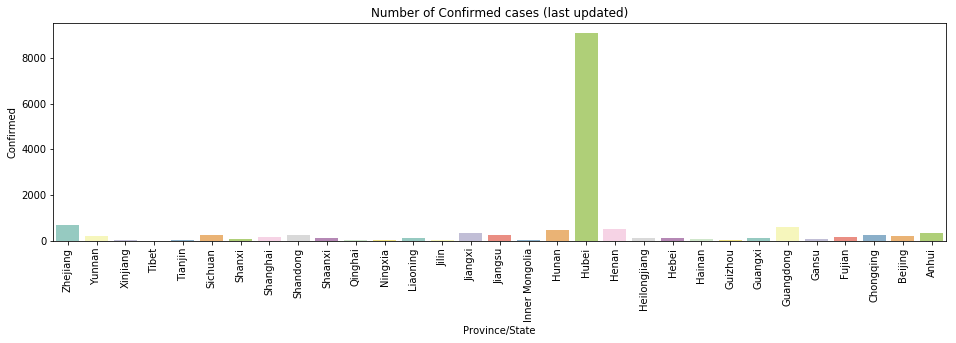

In [20]:
plot_count('Province/State', 'Confirmed', 'Confirmed cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Recovered cases

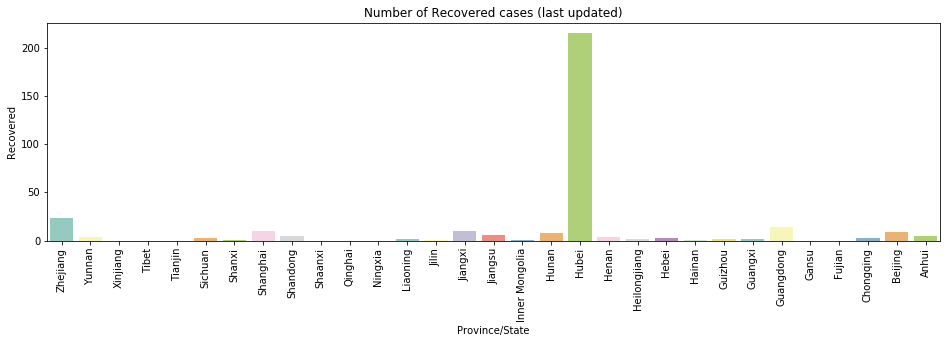

In [21]:
plot_count('Province/State', 'Recovered', 'Recovered cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Deaths

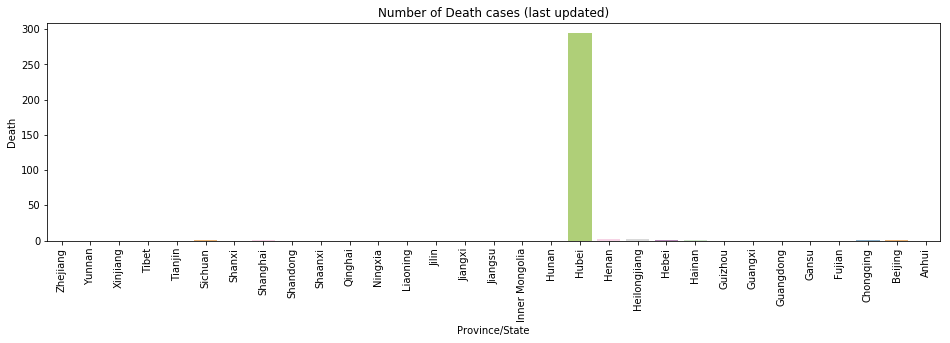

In [22]:
plot_count('Province/State', 'Death', 'Death cases (last updated)', filtered_data_last, size=4)

Now we will show again the confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China, as evolved in time.

In [23]:
def plot_time_variation(df, y='Confirmed', hue='Province/State', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x="Update", y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    plt.title(f'{y} cases grouped by {hue}')
    plt.show()  

#### Mainland China - Confirmed cases - time evolution

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


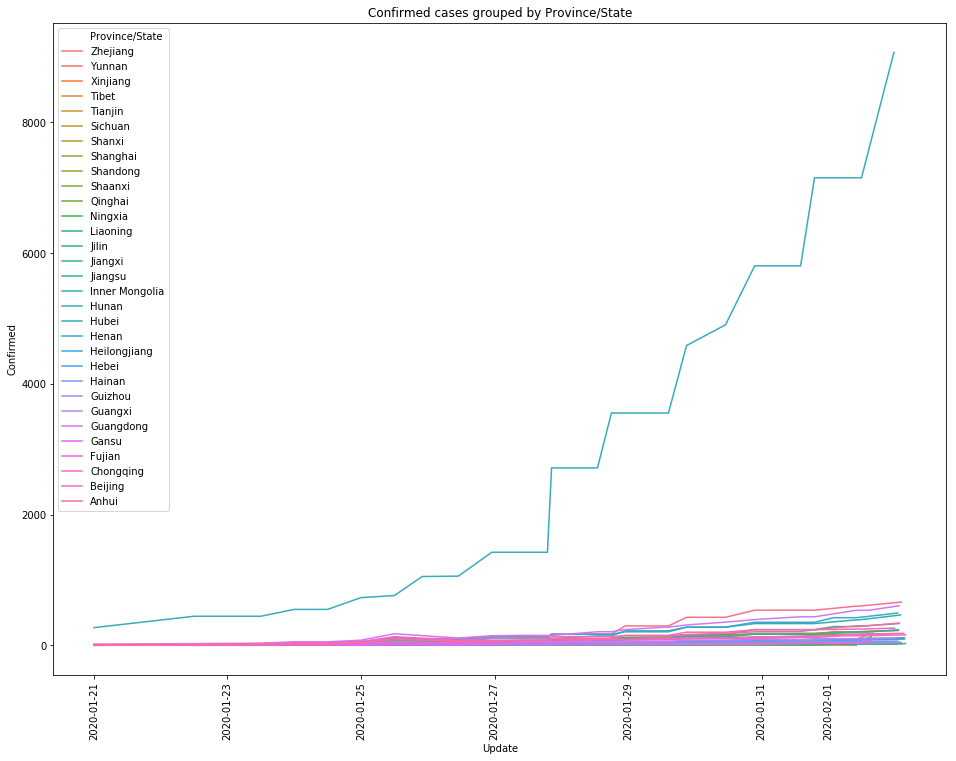

In [24]:
plot_time_variation(data_cn, size=4)

#### Mainland China - Deaths - time evolution

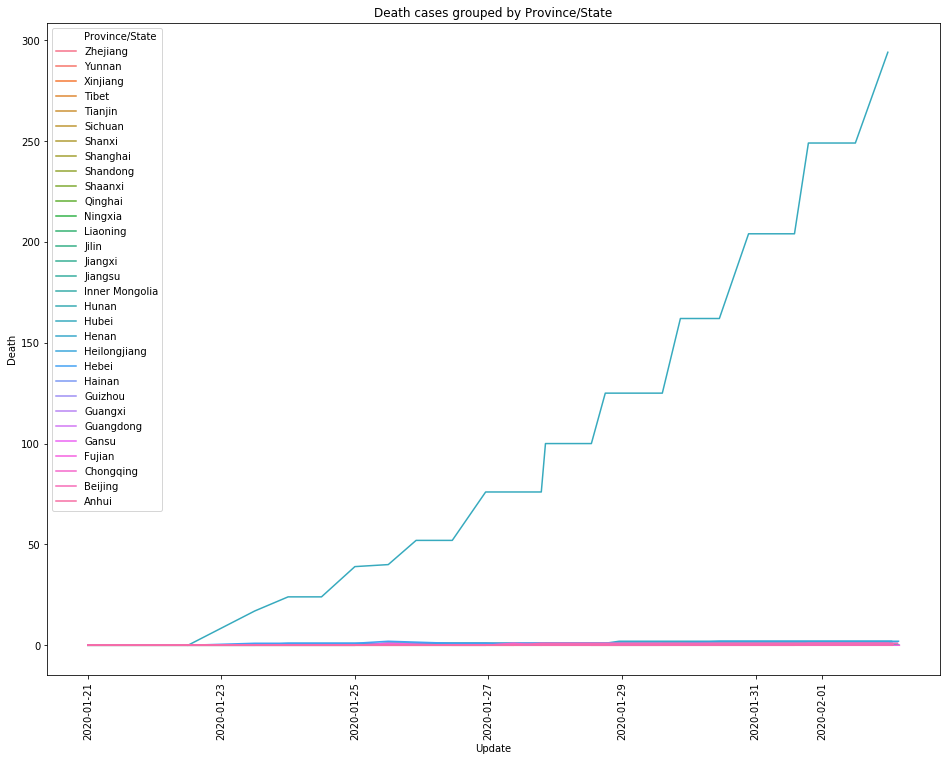

In [25]:
plot_time_variation(data_cn, y='Death', size=4)

#### Mainland China - Recovered cases - time evolution

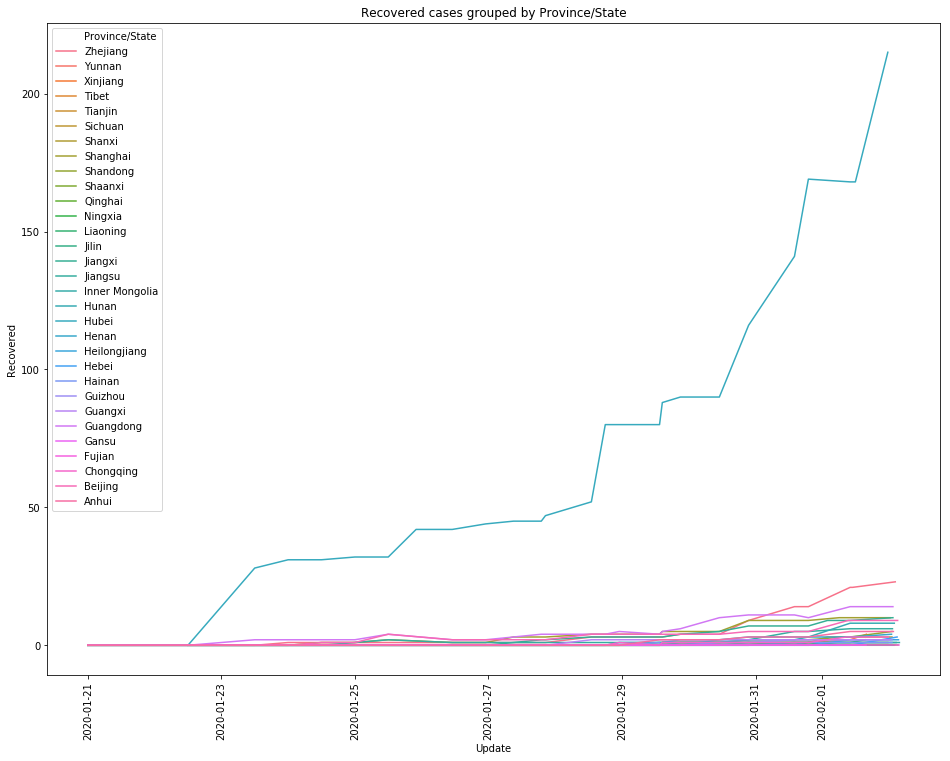

In [26]:
plot_time_variation(data_cn, y='Recovered', size=4)

Let's show only the cases outside Hubei province.

#### Mainland China - Confirmed cases (except Hubei) - time evolution

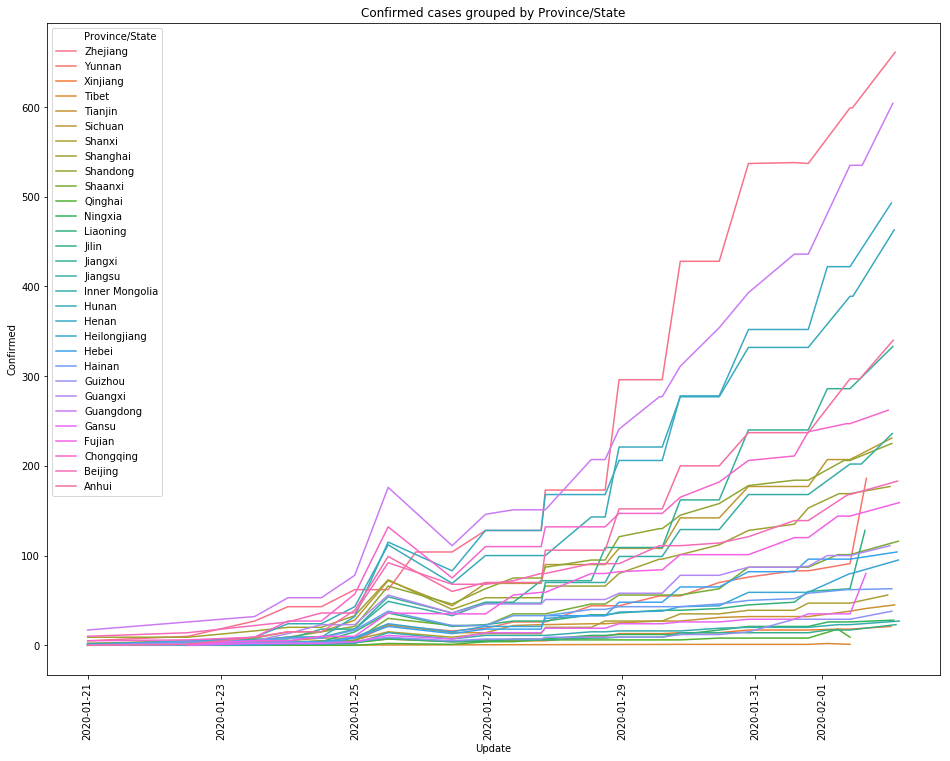

In [27]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], size=4)

#### Mainland China (except Hubei) - Deaths - time evolution

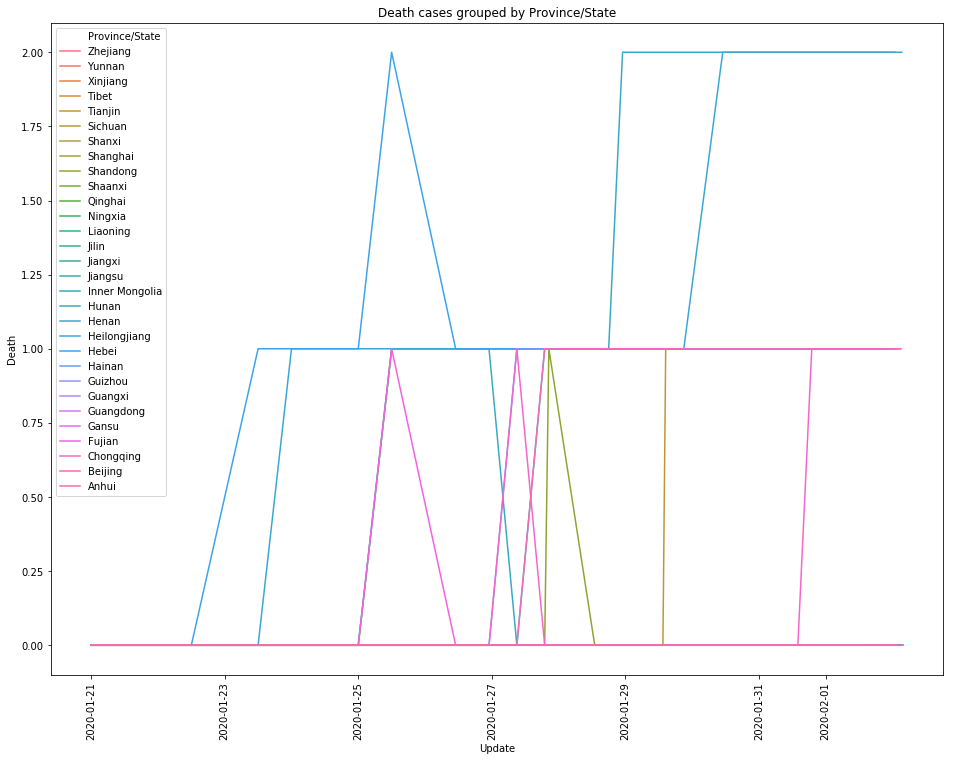

In [28]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], y='Death', size=4)

#### Mainland China (except Hubei) - Recovered cases - time evolution

In [29]:
print(filtered_data_last.shape)
filtered_data_last = filtered_data_last.merge(cn_ll_df, on=['Province/State'])
print(filtered_data_last.shape)


(31, 6)
(31, 8)


In [30]:
filtered_data_last.head()

,Province/State,Update,Confirmed,Suspected,Recovered,Death,lat,lon
0,Zhejiang,2020-02-02 02:13:00,661.0,0.0,23.0,0.0,29.141643,119.788925
1,Yunnan,2020-02-01 15:53:00,186.0,0.0,4.0,0.0,24.475285,101.343106
2,Xinjiang,2020-02-02 00:43:00,21.0,0.0,0.0,0.0,42.524636,87.539586
3,Tibet,2020-02-01 10:00:00,1.0,0.0,0.0,0.0,30.153360,88.787868
4,Tianjin,2020-02-02 02:03:00,45.0,0.0,0.0,0.0,39.343357,117.361648


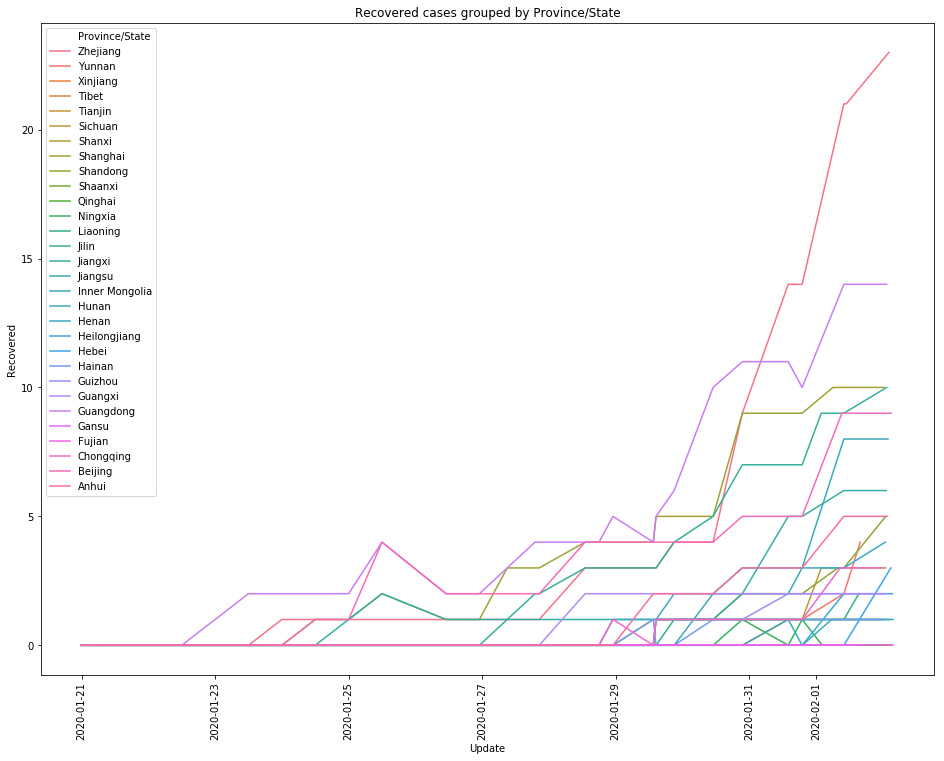

In [31]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')],y='Recovered', size=4)

The following Folium group using **CircleMarker** is created using the inspiration from: https://www.kaggle.com/grebublin/coronavirus-propagation-visualization-forecast Kernel.

In [32]:
m = folium.Map(location=[30, 100], zoom_start=4)

folium.Choropleth(
    geo_data=cn_geo_data,
    name='Confirmed cases - regions',
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.05,
    line_opacity=0.3,
).add_to(m)

radius_min = 2
radius_max = 40
weight = 1
fill_opacity = 0.2

_color_conf = 'red'
group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'lat']
    lon = filtered_data_last.loc[i, 'lon']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Death']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max

    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_conf, 
                        popup = _popup_conf, 
                        color = _color_conf, 
                        fill_opacity = fill_opacity,
                        weight = weight, 
                        fill = True, 
                        fillColor = _color_conf).add_to(group0)

group0.add_to(m)
folium.LayerControl().add_to(m)
m

### Rest of the world (not China)

Let's check now the status in the rest of the world.

In [33]:
data_wd = data_df.loc[~(data_df['Country/Region']=="Mainland China")]
data_wd = pd.DataFrame(data_wd.groupby(['Country/Region', 'DateTime'])['Confirmed', 'Suspected', 'Recovered', 'Death'].sum()).reset_index()
data_wd.columns = ['Country/Region', 'Update', 'Confirmed', 'Suspected', 'Recovered', 'Death' ]
data_wd = data_wd.sort_values(by = ['Country/Region','Update'], ascending=False)

#### Rest of the world (not China) - Confirmed cases

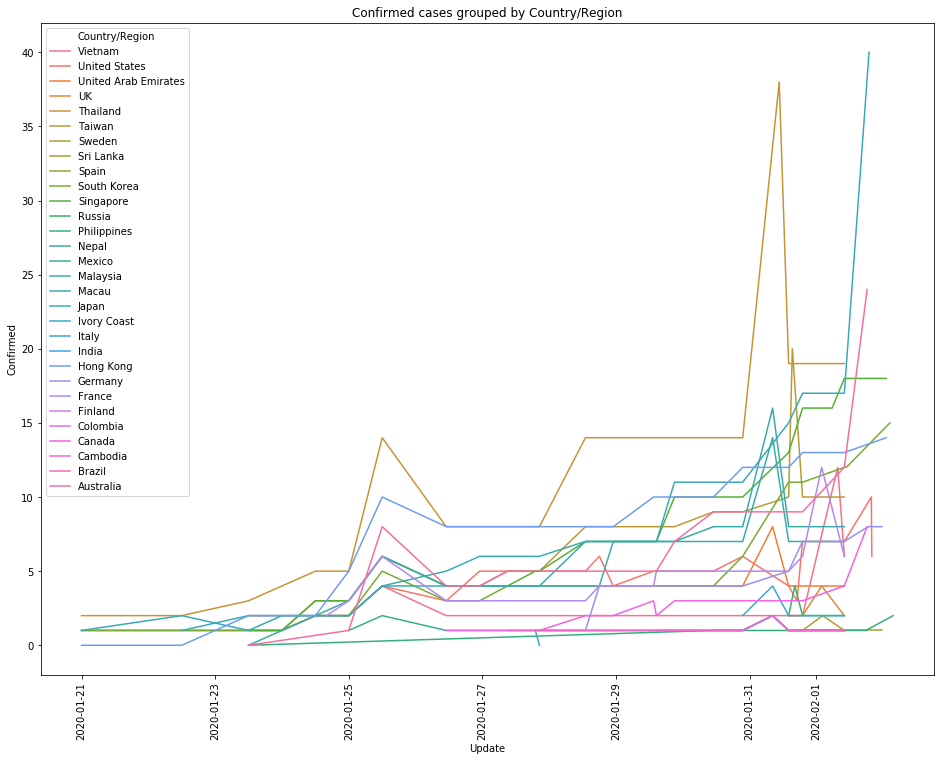

In [34]:
plot_time_variation(data_wd, y='Confirmed', hue='Country/Region', size=4)

#### Rest of the world (not China) - Suspected

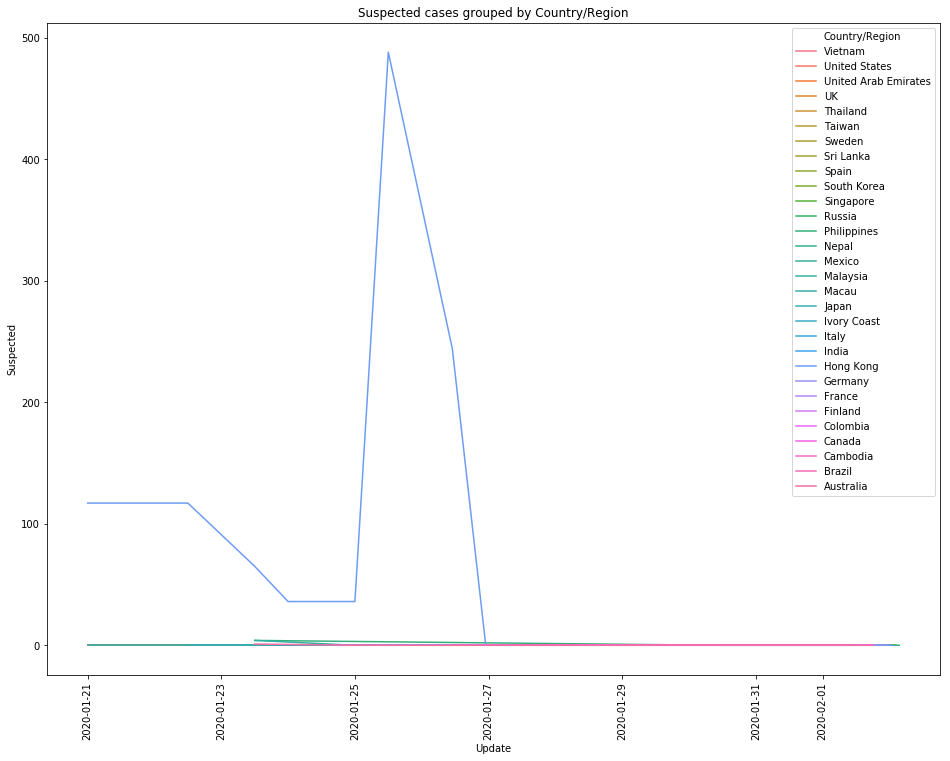

In [35]:
plot_time_variation(data_wd, y='Suspected', hue='Country/Region', size=4)

#### Rest of the world (not China) - Deaths

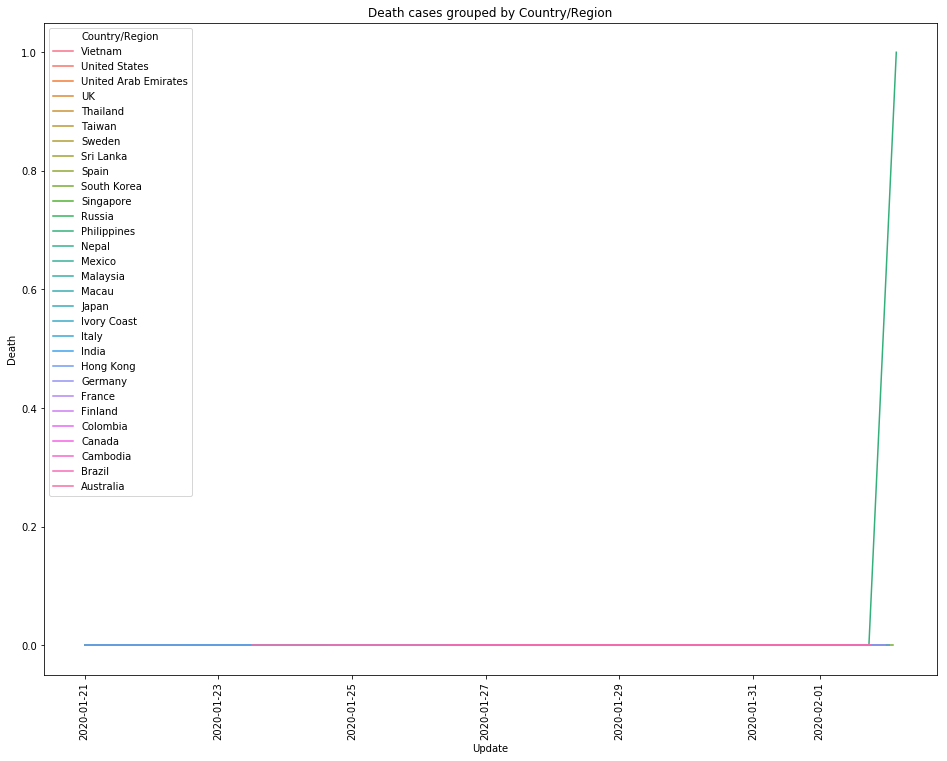

In [36]:
plot_time_variation(data_wd, y='Death', hue='Country/Region', size=4)

#### Rest of the world (not China) - Recovered cases

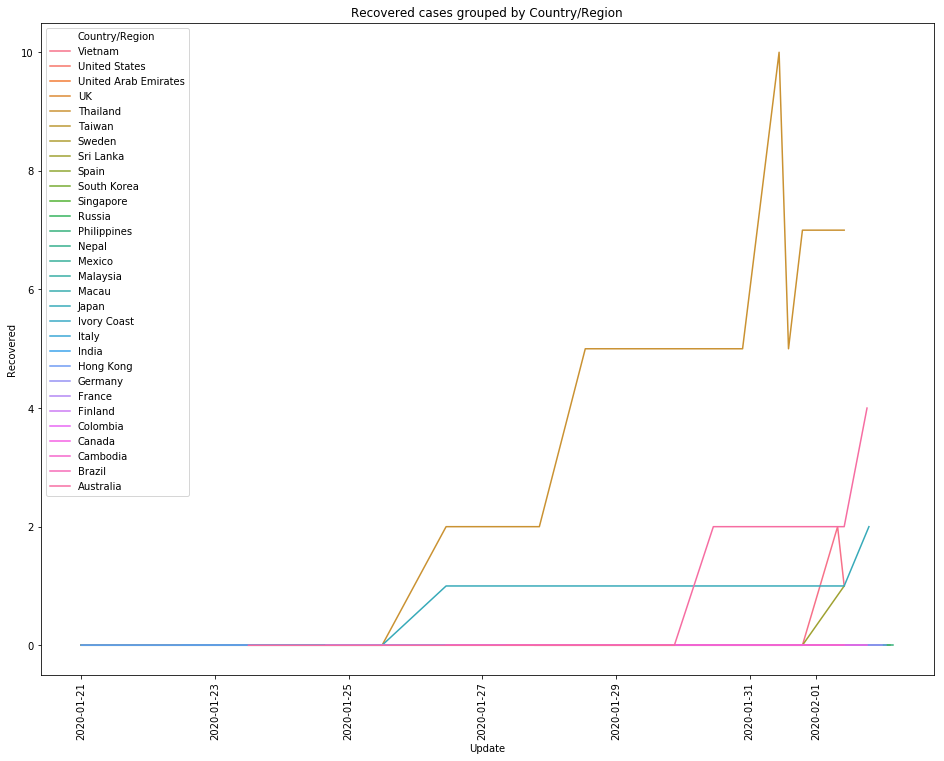

In [37]:
plot_time_variation(data_wd, y='Recovered', hue='Country/Region', size=4)

### Rest of the World - Confirmed cases - last geographical distribution

We show on a map the distribution of confirmed cases (last information).

In [38]:
filtered_wd_data_last = data_wd.drop_duplicates(subset = ['Country/Region'],keep='first')
filtered_wd_data_last

,Country/Region,Update,Confirmed,Suspected,Recovered,Death
411,Vietnam,2020-02-01 10:00:00,6.0,0.0,1.0,0.0
389,United States,2020-02-01 19:53:00,6.0,0.0,0.0,0.0
363,United Arab Emirates,2020-02-01 10:00:00,4.0,0.0,0.0,0.0
354,UK,2020-02-01 10:00:00,2.0,0.0,0.0,0.0
350,Thailand,2020-02-01 10:00:00,19.0,0.0,7.0,0.0
326,Taiwan,2020-02-01 10:00:00,10.0,0.0,0.0,0.0
302,Sweden,2020-02-01 10:00:00,1.0,0.0,0.0,0.0
298,Sri Lanka,2020-02-01 10:00:00,1.0,0.0,1.0,0.0
284,Spain,2020-02-01 23:43:00,1.0,0.0,0.0,0.0
280,South Korea,2020-02-02 02:23:00,15.0,0.0,0.0,0.0


In [39]:
# check the field for country feature name; uncomment the following lines to check the country feature names
#fullJsonString = None
#with open(wd_geo_data, 'r') as f:
#    fullJsonString = f.read().encode('ascii', errors='ignore')
#fullJsonString

### Rest of the World not China) - Confirmed Cases

In [40]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_wd_data_last,
    columns=['Country/Region', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases (not China)'
).add_to(m)

folium.LayerControl().add_to(m)
m

### All World

We show the geographical distribution of the spread of 2019 Coronavirus.

#### All World - Confirmed cases

In [41]:
data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Last Update'])['Confirmed', 'Suspected', 'Recovered', 'Death'].sum()).reset_index()
data_all_wd.columns = ['Country/Region', 'Update', 'Confirmed', 'Suspected', 'Recovered', 'Death' ]
data_all_wd = data_all_wd.sort_values(by = ['Country/Region','Update'], ascending=False)
filtered_all_wd_data_last = data_all_wd.drop_duplicates(subset = ['Country/Region'],keep='first')
filtered_all_wd_data_last.loc[filtered_all_wd_data_last['Country/Region']=='Mainland China', 'Country/Region'] = 'China'
filtered_all_wd_data_last

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Country/Region,Update,Confirmed,Suspected,Recovered,Death
471,Vietnam,2/1/2020 7:38,12.0,0.0,2.0,0.0
449,United States,2/1/2020 19:53,6.0,0.0,0.0,0.0
423,United Arab Emirates,2/1/2020 10:00,4.0,0.0,0.0,0.0
414,UK,2/1/2020 1:52,4.0,0.0,0.0,0.0
410,Thailand,2/1/2020 10:00,19.0,0.0,7.0,0.0
386,Taiwan,2/1/2020 10:00,10.0,0.0,0.0,0.0
362,Sweden,2/1/2020 2:13,2.0,0.0,0.0,0.0
358,Sri Lanka,2/1/2020 10:00,1.0,0.0,1.0,0.0
344,Spain,2/1/2020 2:13,1.0,0.0,0.0,0.0
340,South Korea,2/2/2020 2:23,15.0,0.0,0.0,0.0


In [42]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country/Region', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Deaths

In [43]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='Deaths',
    data=filtered_all_wd_data_last,
    columns=['Country/Region', 'Death'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Deaths'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Recovered cases

In [44]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country/Region', 'Recovered'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Recovered'
).add_to(m)

folium.LayerControl().add_to(m)
m